In [ ]:
%%capture --no-stderr
%pip install --upgrade --quiet  langchain langchain-community langchainhub langchain-chroma bs4
%pip install -qU langchain-openai
!pip gradio_client==0.2.10
!pip install gradio==3.38.0

In [ ]:
from langchain_openai import ChatOpenAI
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from google.colab import drive # Used for mounting Google Drive
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain
from langchain_community.document_loaders import WebBaseLoader
import bs4
from langchain_community.document_loaders import RecursiveUrlLoader

In [ ]:
from urllib.request import Request, urlopen
from urllib.parse import urlparse
from bs4 import BeautifulSoup
import ssl

# Scraping

In [ ]:
def get_sitemap(url):
    req = Request(
        url=url,
        headers={"User-Agent": "Mozilla/5.0"}
    )
    response = urlopen(req)
    xml = BeautifulSoup(
        response,
        "lxml-xml",
        from_encoding=response.info().get_param("charset")
    )
    return xml

In [ ]:
def get_urls(xml, name=None, data=None, verbose=False):
    urls = []
    for url in xml.find_all("url"):
        if xml.find("loc"):
            loc = url.findNext("loc").text
            urls.append(loc)
    return urls

In [ ]:
ssl._create_default_https_context = ssl._create_stdlib_context
url = "https://zerodha.com/varsity/chapter-sitemap2.xml"
xml = get_sitemap(url)
urls = get_urls(xml, verbose=False)

In [ ]:
urls

['https://zerodha.com/varsity/chapter/supplementary-note-the-20-market-depth/',
 'https://zerodha.com/varsity/chapter/key-events-and-their-impact-on-markets/',
 'https://zerodha.com/varsity/chapter/momentum-portfolios/',
 'https://zerodha.com/varsity/chapter/sector-analysis-overview/',
 'https://zerodha.com/varsity/chapter/cement/',
 'https://zerodha.com/varsity/chapter/episode-1-ideas-by-the-lake/',
 'https://zerodha.com/varsity/chapter/why-do-stock-prices-fluctuate/',
 'https://zerodha.com/varsity/chapter/why-should-you-invest/',
 'https://zerodha.com/varsity/chapter/who-are-the-different-actors-in-market/',
 'https://zerodha.com/varsity/chapter/why-and-how-do-companies-list-and-what-is-an-ipo/',
 'https://zerodha.com/varsity/chapter/understanding-corporate-actions-like-dividends-bonuses-and-buybacks/',
 'https://zerodha.com/varsity/chapter/understanding-the-various-order-types/',
 'https://zerodha.com/varsity/chapter/getting-started-2/',
 'https://zerodha.com/varsity/chapter/what-is

# Building RAG

In [ ]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass()

··········


## Vector Database

In [ ]:
docs = []
for i, url in enumerate(urls):
    loader = WebBaseLoader(url)
    docs.extend(loader.load())
    if i % 10 == 0:
        print("i", i)

i 0
i 10
i 20
i 30
i 40
i 50
i 60
i 70
i 80
i 90


In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000,
                                               chunk_overlap=200)
splits = text_splitter.split_documents(docs)
vectorstore = Chroma.from_documents(documents=splits,
                                    embedding=OpenAIEmbeddings())
retriever = vectorstore.as_retriever()

In [ ]:
print("len(docs)", len(docs), "len(splits)", len(splits))
print("On average each document is split into", len(splits) / len(docs))

len(docs) 98 len(splits) 1311
On average each document is split into 13.377551020408163


### Testing

In [ ]:
res = vectorstore.similarity_search("What are index funds?")

In [ ]:
print(res)

[Document(metadata={'description': 'A mutual fund is a pooled investment vehicle that collects the money from various investors, invests and manages that money on their behalf.', 'language': 'en-US', 'source': 'https://zerodha.com/varsity/chapter/exchange-traded-funds-etf/', 'title': 'Exchange-traded funds (ETF) – Varsity by Zerodha'}, page_content='29.9 – ETF vs index funds\nThis is another question that keeps coming up. Hopefully, this table should help answer these questions. In short, if you want to have active control or if you are actively using passive ETFs, then ETFs are a better choice. But if you are lazy like me and want to make as fewer choices as possible, then index funds are a better choice.\nWith ETFs, you can express tactical strategies better than index funds because you can’t buy and sell index funds immediately.'), Document(metadata={'description': 'A mutual fund is a pooled investment vehicle that collects the money from various investors, invests and manages that 

## LLM Prompting

In [ ]:
# 2. Incorporate the retriever into a question-answering chain.
system_prompt = (
    "You are a financial assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "If the question is not clear ask follow up questions"
    "\n\n"
    "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)

In [ ]:
llm = ChatOpenAI(model="gpt-3.5-turbo-0125")

In [ ]:
question_answer_chain = create_stuff_documents_chain(llm, prompt)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)

In [ ]:
response = rag_chain.invoke({"input": "What is index fund?"})
print("Response is\n------")
print(response["answer"])
# print(response["context"])

Response is
------
An index fund is a type of mutual fund or exchange-traded fund (ETF) that aims to replicate the performance of a specific financial market index, such as the S&P 500. Index funds provide broad market exposure and are passively managed, meaning they do not involve actively selecting investments. Investors choose index funds for their low costs and ability to match the returns of the chosen index.


In [ ]:
response = rag_chain.invoke({"input": "I want to give someone the right to manage my assists, what should I do?"})
print("Response is\n------")
print(response["answer"])
# print(response["context"])

Response is
------
You can consider setting up a trust or a power of attorney to grant someone the authority to manage your assets. A trust allows you to transfer ownership of assets to a trustee, who manages them for the benefit of the beneficiaries you choose. Alternatively, a power of attorney gives someone the legal authority to make decisions on your behalf regarding your assets while you are alive. Consulting with a legal professional is recommended to determine the best option based on your specific needs and circumstances.


# Adding History

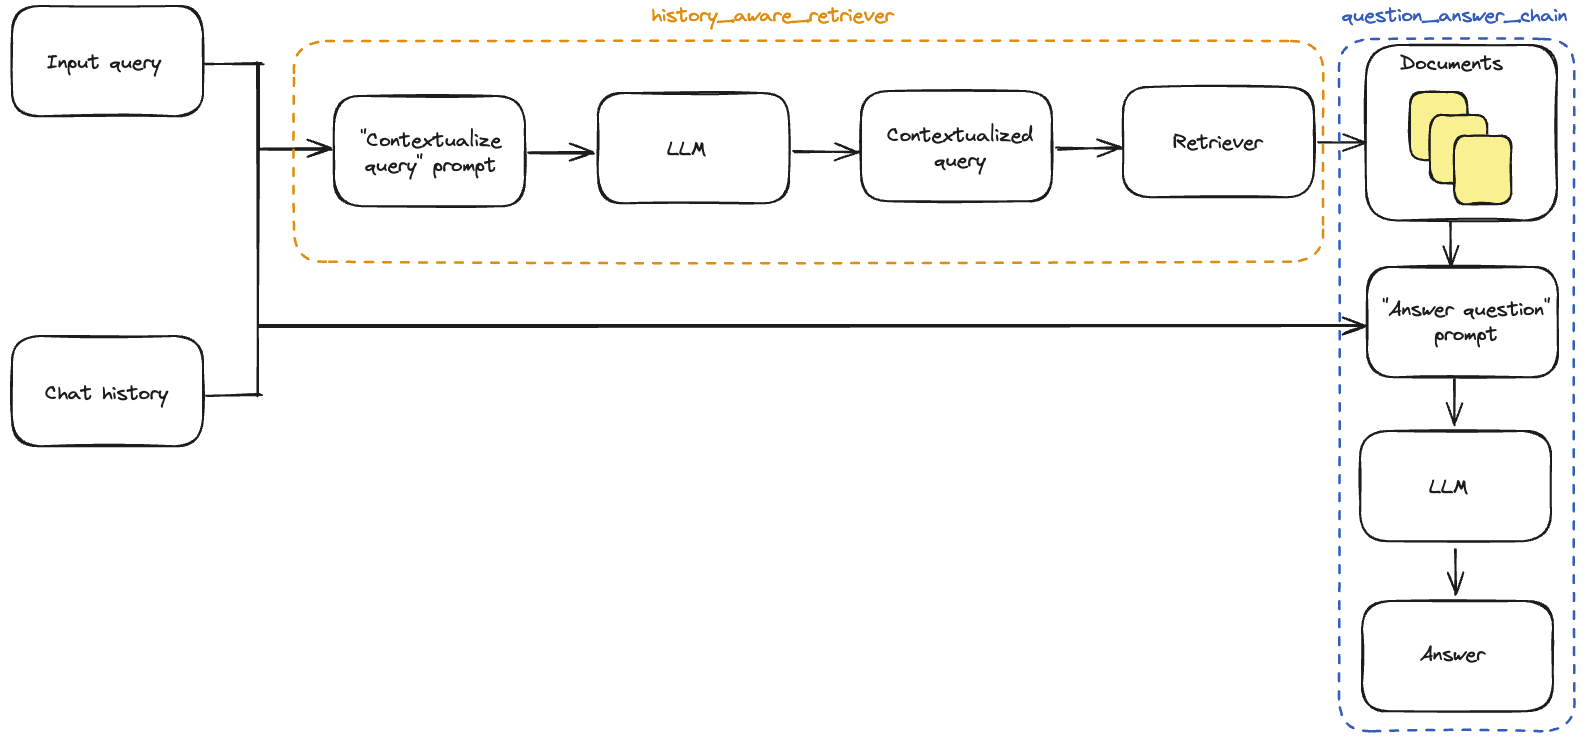

In [ ]:
from langchain.chains import create_history_aware_retriever
from langchain_core.prompts import MessagesPlaceholder

contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)

contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
# If there is no chat_history, then the input is just passed directly to the
# retriever. If there is chat_history, then the prompt and LLM will be used to
# generate a search query. That search query is then passed to the retriever.

# This chain prepends a rephrasing of the input query to our retriever,
# so that the retrieval incorporates the context of the conversation.

history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_q_prompt
)

In [ ]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain

qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)

question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)

# history_aware_retriever and question_answer_chain in sequence, retaining
# intermediate outputs such as the retrieved context for convenience.
# It has input keys input and chat_history, and includes input, chat_history,
# context, and answer in its output.
rag_chain = create_retrieval_chain(history_aware_retriever,
                                   question_answer_chain)

In [ ]:
from langchain_core.messages import AIMessage, HumanMessage

chat_history = []

question = "What is index fund?"
ai_msg_1 = rag_chain.invoke({"input": question, "chat_history": chat_history})
chat_history.extend(
    [
        HumanMessage(content=question),
        AIMessage(content=ai_msg_1["answer"]),
    ]
)

second_question = "What are examples of it?" # What are examples of index funds?
ai_msg_2 = rag_chain.invoke({"input": second_question, "chat_history": chat_history})

print(ai_msg_2["answer"])

Examples of index funds include those that track popular indices like the S&P 500, Dow Jones Industrial Average, NASDAQ Composite, Russell 2000, and MSCI EAFE. These index funds aim to replicate the performance of the underlying index by holding the same stocks in the same proportions as the index itself, providing investors with diversified exposure to a specific market or segment.


# Gradio

In [ ]:
import gradio as gr

/usr/local/lib/python3.10/dist-packages/gradio_client/documentation.py:106: UserWarning: Could not get documentation group for <class 'gradio.mix.Parallel'>: No known documentation group for module 'gradio.mix'
  warnings.warn(f"Could not get documentation group for {cls}: {exc}")
/usr/local/lib/python3.10/dist-packages/gradio_client/documentation.py:106: UserWarning: Could not get documentation group for <class 'gradio.mix.Series'>: No known documentation group for module 'gradio.mix'
  warnings.warn(f"Could not get documentation group for {cls}: {exc}")


In [ ]:
from langchain_core.messages import AIMessage, HumanMessage

def predict(question, chat_history):
  history_for_llm = []
  for tup in chat_history:
    history_for_llm.extend([HumanMessage(tup[0]), AIMessage(tup[1])])

  ai_msg = rag_chain.invoke({"input": question, "chat_history": history_for_llm})
  return ai_msg["answer"]

In [ ]:
demo = gr.ChatInterface(predict,
    chatbot=gr.Chatbot(height=300),
    textbox=gr.Textbox(placeholder="Hi I am your virtual assistant, how can I help you today?", container=False, scale=7),
    title="DocumentQABot",
    theme="soft",
    examples=["What is the weather like in SF?", "What is LangSmith?"],
    retry_btn=None,
    undo_btn="Delete Previous",
    clear_btn="Clear",)
demo.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
IMPORTANT: You are using gradio version 3.38.0, however version 4.29.0 is available, please upgrade.
--------
Running on public URL: https://f16a59b6b08727504a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://f16a59b6b08727504a.gradio.live
